# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

#  Number of testing examples.
n_test = len(X_test)

#  Shape of an traffic sign image
image_shape = X_train[0].shape

#  Unique classes/labels  in the dataset.
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = len(class_counts)

print("Number of training examples =", n_train)
print("Number of validing examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validing examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). 

* plotting traffic sign images
* plotting the count of each sign, etc. 


21


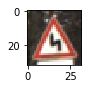

In [4]:
### Data exploration visualization 
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

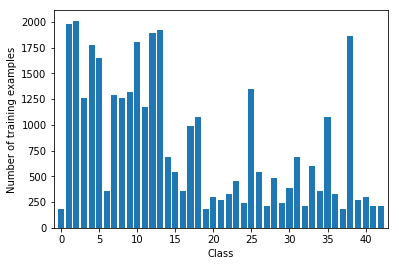

In [5]:
plt.bar( np.arange( 43 ), class_counts, align='center' )
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

The image data is normalized by equalize histogram method so that the data has mean zero and equal variance. 

8


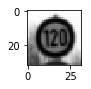

In [6]:
### Preprocess 
from skimage import exposure
from sklearn.utils import shuffle

#convert image to grayscale
X_train_gray = 0.299 * X_train[:, :, :, 0] + 0.587 * X_train[:, :, :, 1] + 0.114 * X_train[:, :, :, 2]
X_valid_gray = 0.299 * X_valid[:, :, :, 0] + 0.587 * X_valid[:, :, :, 1] + 0.114 * X_valid[:, :, :, 2]
X_test_gray =  0.299 * X_test[:, :, :, 0] + 0.587 * X_test[:, :, :, 1] + 0.114 * X_test[:, :, :, 2]

# normalize data and apply histogram equalize
X_train_normalize = exposure.equalize_hist(X_train_gray/255.)
X_valid_normalize = exposure.equalize_hist(X_valid_gray/255.)
X_test_normalize = exposure.equalize_hist(X_test_gray/255.)

#Add Channel
X_train_normalize = X_train_normalize.reshape(X_train_normalize.shape + (1,))
X_valid_normalize = X_valid_normalize.reshape(X_valid_normalize.shape + (1,))
X_test_normalize = X_test_normalize.reshape(X_test_normalize.shape + (1,))

#Show image after preprocessing
index = random.randint(0, len(X_train_normalize))
image = X_train_normalize[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image,cmap = "gray")
print(y_train[index])

#Shuffle the data
X_train_normalize, y_train = shuffle(X_train_normalize, y_train)


### Model Architecture

In [7]:
### Define model architecture 
import tensorflow as tf
from tensorflow.contrib.layers import flatten
#Initialize global variable to visualize layer
test_layer = None

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #  Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    #  Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    

    #  Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob) 


    #  Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)
    #Visualize fc2 layer using global variable
    global test_layer
    test_layer = conv1

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
def evaluate(X_data, y_data):
    '''
    Evaluate function
    '''
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#initialize  and parameter
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

EPOCHS = 100
BATCH_SIZE = 256

keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

rate = 0.0008

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()



#Run Graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalize)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalize, y_train = shuffle(X_train_normalize, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalize[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid_normalize, y_valid)
        if ((i+1) % 10 ==0):
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, './model.ckpt')
    print("Model saved")


Training...

EPOCH 10 ...
Validation Accuracy = 0.899

EPOCH 20 ...
Validation Accuracy = 0.936

EPOCH 30 ...
Validation Accuracy = 0.936

EPOCH 40 ...
Validation Accuracy = 0.931

EPOCH 50 ...
Validation Accuracy = 0.942

EPOCH 60 ...
Validation Accuracy = 0.949

EPOCH 70 ...
Validation Accuracy = 0.952

EPOCH 80 ...
Validation Accuracy = 0.951

EPOCH 90 ...
Validation Accuracy = 0.954

EPOCH 100 ...
Validation Accuracy = 0.963

Model saved


---

## Step 3: Test a Model on New Images

Five pictures of German traffic signs are downloaded from the web and this model is used to predict the traffic sign type.

### Load and Output the Images

German Traffic Sign from web:



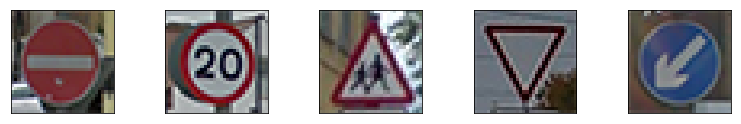

In [10]:
### Load the images and plot them here.
import matplotlib.image as mpimg

#number of photo
n_photo = 5

#Innitial
img = np.zeros((n_photo,32,32,4))
img_gray = np.zeros((n_photo,32,32))
img_normalize = np.zeros((n_photo,32,32))

#Read photo & Preprocessing
for i in range(n_photo):
    img[i] = mpimg.imread( './Predict/' + "predict_0"+str(i+1)+ '.png')
    img_gray[i]= 0.299 * img[i ,:, :, 0] + 0.587 * img[ i,:, :, 1] + 0.114 * img[i,:, :, 2]
    img_normalize[i] = exposure.equalize_hist(img_gray[i]/255)

#Add one channel to data
img_normalize = img_normalize.reshape(img_normalize.shape + (1,))

#Output Images
print('German Traffic Sign from web:\n')

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.5)
for i in range(n_photo):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(img[i])
plt.show()

#Provide answer 
label_ans = np.array([
    17, #No entry
    0, # Speed limit (20km/h)
    28, #Children crossing
    13, #Yield
    39    #Keep left
])

### Predict the Sign Type for Each Image

In [11]:
### Run the predictions 
import pandas as pd
import matplotlib.gridspec as gridspec

#Read sign name from data
traffic_sign_labels = pd.read_csv('./signnames.csv')
label = traffic_sign_labels["SignName"]

#Load  trained model
saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess,'./model.ckpt')
    #Get prediction
    predict = sess.run( tf.nn.softmax(logits) , feed_dict={x: img_normalize, keep_prob:1})




Input:


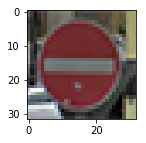

Model Prediction: This is a No entry traffic sign!
 .........................................................................

Input:


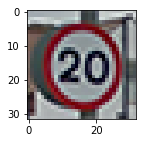

Model Prediction: This is a Speed limit (20km/h) traffic sign!
 .........................................................................

Input:


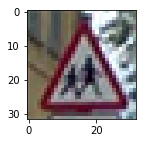

Model Prediction: This is a Children crossing traffic sign!
 .........................................................................

Input:


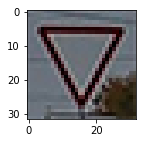

Model Prediction: This is a Yield traffic sign!
 .........................................................................

Input:


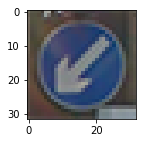

Model Prediction: This is a Keep left traffic sign!
 .........................................................................



In [12]:
for i in range(n_photo):
    print('Input:')
    plt.figure(figsize=(2, 2))
    ima = img[i]
    plt.imshow(ima)
    plt.show()
    print('Model Prediction: This is a' ,label[predict[i].argmax()], 'traffic sign!\n','.........................................................................\n')

### Analyze Performance

In [13]:
### Calculate the accuracy for these 5 new images. 
count =0

for i in range(n_photo):
    if (predict[i].argmax() == label_ans[i]):
        count+=1
    else:
        count = count

print('Performance:' , count*100/n_photo,'%')

Performance: 100.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

 [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) is used here to return the values and indices (class ids) of the top 5 predictions.



TopKV2(values=array([[ 49.51117706,   7.43571663,   3.79508185,   1.07551873,
          0.17056794],
       [ 32.14767456,  12.43948936,  11.60831261,   6.67387295,
          5.50333357],
       [ 35.5543251 ,  13.85436344,   7.18587494,   6.95846796,
          4.62750387],
       [ 55.74245071,  14.60551262,   5.07479906,   0.2315027 ,
         -0.40491408],
       [ 54.02745056,  10.47014713,   5.2862215 ,   5.20570374,
          4.59344769]], dtype=float32), indices=array([[17, 34, 26, 20,  8],
       [ 0,  4,  8, 40,  1],
       [28, 11, 29, 30, 20],
       [13, 15,  2, 38, 12],
       [39, 31, 29,  2, 25]]))


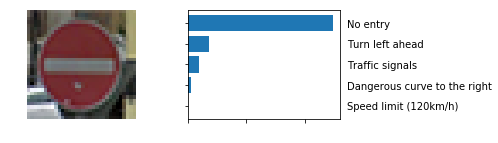

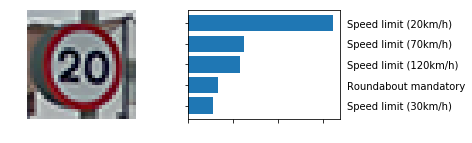

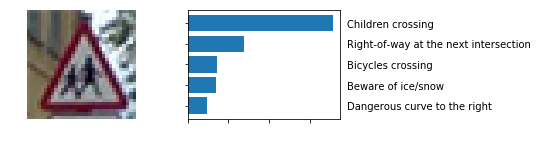

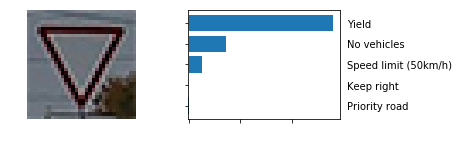

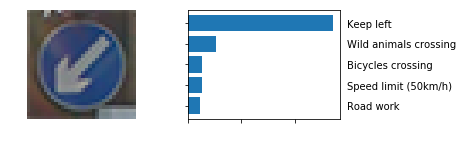

In [18]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

#Load  trained model
saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess,'./model.ckpt')
    #Get prediction
    top_5 = sess.run( tf.nn.top_k(logits, k=5, sorted=True, name=None) , feed_dict={x: img_normalize, keep_prob:1})

    print(top_5)
    
#Plot prediction for each image
for i in range(n_photo):
    # Prepare the grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
        
    # Plot original image
    plt.subplot2grid((1, 2), (0,0),colspan=1, rowspan=1)
    plt.imshow(img[i])
    plt.axis('off')

    # Plot predictions
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(5-np.arange(5)+0.5, top_5[0][i], align='center')
    plt.yticks(5-np.arange(5)+0.5, label[top_5[1][i].astype(int)])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
        
    plt.show()


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


In [1]:
### Visualize the network's feature maps 

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):

    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

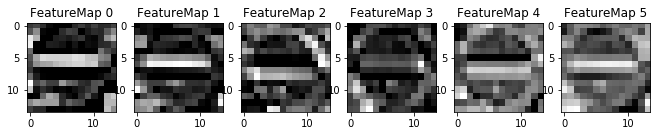

In [16]:
#read test image
img_test = np.zeros((1,32,32,4))
img_test_gray = np.zeros((1,32,32))
img_test_normalize = np.zeros((1,32,32))
img_test[0] = mpimg.imread( './Predict/predict_01.png')
img_test_gray[0]= 0.299 * img_test[0 ,:, :, 0] + 0.587 * img_test[ 0,:, :, 1] + 0.114 * img_test[0,:, :, 2]
img_test_normalize[0] = exposure.equalize_hist(img_test_gray[0]/255)

#Add one channel to data
img_test_normalize = img_test_normalize.reshape(img_test_normalize.shape + (1,))


# Visualize the conv1 layer
with tf.Session() as sess:
    saver.restore(sess,'./model.ckpt')
    outputFeatureMap(img_test_normalize, tf_activation=test_layer)
    plt.show()

## Test Set Accuracy

In [17]:
#Load  trained model
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,'./model.ckpt')
    test_accuracy = evaluate(X_test_normalize, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))
    
    

Test Set Accuracy = 0.942
